# AutoML: Automating machine learning applied to areal regression modeling

This tutorial was presented [EO Council Opengeohub Summer School Wageningen 2025](https://opengeohub.org/summer-school/summer-school-2025) and is part of the projects: Open-Earth-Monitor Cyberinfrastructure (Grant No. [101059548](https://cordis.europa.eu/project/id/101059548/results) and the [Land & Carbon Global Pasture Watch[(https://landcarbonlab.org/about-global-pasture-watch/).

Key modeling aspects (see [presentation slides](https://docs.google.com/presentation/d/1qePs0puoVaVaVysztSlqLadb4_YIxQNf2JeuaF5GWlI)):
- **Livestock census data**: You will use a compilation of subnational livestock census data for the Brazilian [state Goiás](https://nl.wikipedia.org/wiki/Goiás_(staat)), which annual headcount estimates for cattle, goat, sheep, horse and buffalo at municipally levels (247 polygons),

- **Harmonized raster layers**: The raster layers are provided in different spatial/temporal resolutions and will be harmonized via [gdalbuildvrt](https://gdal.org/en/stable/programs/gdalbuildvrt.html), resulting in a standardized 1-km annual [data cube computed on-the-fly](https://gitlab.com/leal.parente/geo-snippets/-/blob/main/data_cubes/WRI_Summit_2023_Accessing_Imagery_Collections_Raster_Data_Cubes_STAC.ipynb?ref_type=heads),

- **Potential land for livestock production**: Raster layer representing the fraction of land (grassland & cropland combined) where the livestock animals obtain food. This layer will be used to select which pixel must be included in zonal statistics and estimate the total area used for livestock activity,

- **Spatiotemporal zonal statistics**: computation of spatial mean (all input features/covariates) and sum (potential land for livestock production) for each census polygon on a annual basis,

- **Spatiotemporal areal regression**: Train and evaluate (spatial cross-validation and 20% for test set) a default Random Forest regressor ([scikit-learn](https://scikit-learn.org/stable/)) and model selected by a AutoML ([EvalML](https://evalml.alteryx.com/en/stable/user_guide/automl.html)),

- **Spatiotemporal gridded prediction**: Use the harmonized raster layers and the trained models to predict gridded output with 1-km spatial resolution on a annual basis.

# Installing the libraries

First you need to install [scikit-map](https://github.com/openlandmap/scikit-map):

In [ ]:
!pip uninstall -y scikit-map

In [ ]:
!pip install "scikit-map[full]" 'git+https://github.com/openlandmap/scikit-map@eo-summer-school'

..and make sure that GDAL is installed in your operation system. If the following command fails, you need to find your way to [install GDAL](https://mapscaping.com/installing-gdal-for-beginners/).

In [9]:
!gdalinfo --version

GDAL 3.10.3, released 2025/04/01


In most of Debian based linux distribution, including ubuntu, GDAL can be installed by:

In [ ]:
!apt install -y gdal-bin

To have access to several functions used in this tutorial you need to download:

In [282]:
# Download file

...and import `misc.py`. If any library fails to load, you need to find your way to install it using [pip](https://pypi.org/project/pip/), [conda](https://anaconda.org/anaconda/conda) or [mamba](https://mamba.readthedocs.io/en/latest/user_guide/mamba.html):

In [1]:
import misc

You might need to install the following libraries:

In [ ]:
!pip install evalml wget

...and other necessary libraries:

In [2]:
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GroupKFold
from skmap import io
from skmap.misc import ttprint

import geopandas as gpd
import misc
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tarfile
import wget

sns.set_context("notebook")
sns.set_theme(style="whitegrid", palette="pastel")

# Downloading census data and raster layers

All data necessary to run the modeling is organized in a compressed file, so let's download it using [wget](https://pypi.org/project/wget/):

In [6]:
base_url = 'https://s3.eu-central-1.wasabisys.com/ogh/tmp'
file = 'livestock_areal_regression_ogh_summer_school_2025.tar.gz'
wget.download(f'{base_url}/{file}')

Now, let's extract it:

In [8]:
tar = tarfile.open(file)
tar.extractall()
tar.close()

# Loading census data

Let's load the subnational livestock census data:

In [3]:
polygon_fn = 'gpw_livestock.animals_ibge_polygon.samples_20000101_20241231_br.go_epsg.4326_v1.gpkg'

polygon_samples = gpd.read_file(polygon_fn)
polygon_samples

,gazID,gazName,country,level,source,buffalo_2000,buffalo_2001,buffalo_2002,buffalo_2003,buffalo_2004,...,sheep_2021,sheep_2022,sheep_2023,sheep_2024,cattle_nyears,goat_nyears,horse_nyears,sheep_nyears,buffalo_nyears,geometry
0,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,Brazil,3,GPW,NaN,NaN,NaN,NaN,NaN,...,110.0,130.0,NaN,NaN,24,24,24,24,12,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398..."
1,.002.003.003.009.002,Brazil.Goiás.Abadiânia,Brazil,3,GPW,40.0,40.0,45.0,50.0,60.0,...,684.0,694.0,NaN,NaN,24,24,24,24,23,"MULTIPOLYGON (((-48.61291 -16.14283, -48.60518..."
2,.002.003.003.009.003,Brazil.Goiás.Acreúna,Brazil,3,GPW,400.0,300.0,200.0,NaN,NaN,...,174.0,146.0,NaN,NaN,24,24,24,19,19,"MULTIPOLYGON (((-50.0736 -17.46149, -50.07881 ..."
3,.002.003.003.009.004,Brazil.Goiás.Adelândia,Brazil,3,GPW,12.0,11.0,12.0,13.0,15.0,...,50.0,6.0,NaN,NaN,24,14,24,14,23,"MULTIPOLYGON (((-50.13351 -16.33688, -50.13582..."
4,.002.003.003.009.005,Brazil.Goiás.Água Fria de Goiás,Brazil,3,GPW,30.0,34.0,NaN,NaN,NaN,...,1463.0,1582.0,NaN,NaN,24,24,24,24,12,"MULTIPOLYGON (((-47.57374 -15.04709, -47.67991..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,.002.003.003.009.254,Brazil.Goiás.IPIRANGA DE GOIÁS,Brazil,3,GPW,NaN,NaN,NaN,NaN,NaN,...,83.0,81.0,NaN,NaN,23,23,23,23,3,"MULTIPOLYGON (((-49.60871 -15.04302, -49.61117..."
243,.002.003.003.009.255,Brazil.Goiás.ITAJÁ,Brazil,3,GPW,215.0,220.0,225.0,227.0,220.0,...,1400.0,1470.0,NaN,NaN,24,24,24,24,23,"MULTIPOLYGON (((-51.64919 -18.79389, -51.64539..."
244,.002.003.003.009.256,Brazil.Goiás.LAGOA SANTA,Brazil,3,GPW,NaN,NaN,NaN,NaN,7.0,...,630.0,719.0,NaN,NaN,24,23,24,23,19,"MULTIPOLYGON (((-51.22211 -19.15881, -51.20879..."
245,.002.003.003.009.257,Brazil.Goiás.SILVÂNIA,Brazil,3,GPW,110.0,120.0,115.0,110.0,115.0,...,1300.0,1050.0,NaN,NaN,24,24,24,24,23,"MULTIPOLYGON (((-48.41155 -16.28667, -48.40971..."


...and check polygons:

<Axes: >

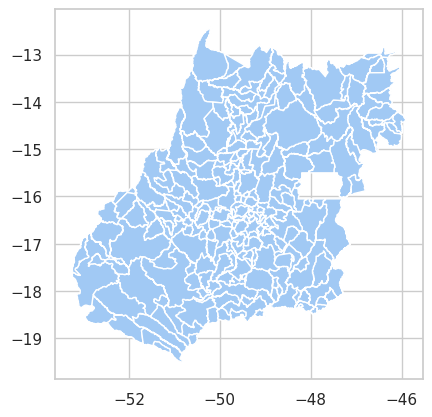

In [4]:
polygon_samples.plot()

# Harmonizing raster layers

In [6]:
livestock_covs = pd.read_csv(f'livestock_cov.csv')
livestock_covs

,url,type,start_year,end_year,layername,spatial_res
0,https://s3.opengeohub.org/global/dtm/v3/hillsh...,static,NaN,NaN,hillshade_edtm_m_960m_s_20000101_20221231_go_e...,960m
1,https://s3.opengeohub.org/global/dtm/v3/slope....,static,NaN,NaN,slope.in.degree_edtm_m_960m_s_20000101_2022123...,960m
2,https://s3.opengeohub.org/global/lcv/lcv_acces...,static,NaN,NaN,lcv_accessibility.to.cities_map.ox.var10_m_1km...,1km
3,https://s3.opengeohub.org/global/lcv/lcv_acces...,static,NaN,NaN,lcv_accessibility.to.cities_map.ox.var11_m_1km...,1km
4,https://s3.opengeohub.org/global/lcv/lcv_acces...,static,NaN,NaN,lcv_accessibility.to.cities_map.ox.var12_m_1km...,1km
5,https://s3.opengeohub.org/global/lcv/lcv_water...,static,NaN,NaN,lcv_water.occurance_jrc.surfacewater_p_250m_b0...,250m
6,https://s3.opengeohub.org/global/aridity.index...,static,NaN,NaN,aridity.index_gai.pet.m01_m_1km_s_19700101_200...,1km
7,https://s3.opengeohub.org/global/aridity.index...,static,NaN,NaN,aridity.index_gai.pet.m02_m_1km_s_19700101_200...,1km
8,https://s3.opengeohub.org/global/aridity.index...,static,NaN,NaN,aridity.index_gai.pet.m03_m_1km_s_19700101_200...,1km
9,https://s3.opengeohub.org/global/aridity.index...,static,NaN,NaN,aridity.index_gai.pet.m04_m_1km_s_19700101_200...,1km


In [10]:
livestock_covs['spatial_res'].unique()

array(['960m', '1km', '250m', '10km'], dtype=object)

In [11]:
livestock_covs['r_method'] = livestock_covs['spatial_res'].replace({
    '960m': 'near',
    '1km': 'near',
    '250m': 'average',
    '10km': 'cubicspline',
})

In [12]:
tr = '1000 1000'
t_srs = '+proj=igh +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'

ulx, lry, lrx, uly = polygon_samples.to_crs(t_srs).total_bounds
te = f'{ulx} {lry} {lrx} {uly}'

In [13]:
indir = 'raster_layers'
outdir = 'datacube'
end_year = 2022

os.makedirs(outdir, exist_ok=True)

with open(f"gen_datacube.in", "w") as outfile:
    cmds = misc.gdalwarp_cmds(livestock_covs, indir, outdir, end_year, te, tr, t_srs)
    for line in cmds:
        outfile.write(f"{line}\n")

print(f'Size: {len(cmds)}')
if len(cmds) > 0:
    print(f'First: {cmds[0]}')

Size: 0


# Spatiotemporal zonal statistics

In [7]:
base_path = 'datacube'
static_covs = [ l for l in livestock_covs[livestock_covs['type'] == 'static'].layername ]
temporal_covs = [ l for l in livestock_covs[livestock_covs['type'] == 'temporal'].layername ]

## Single polygon

In [15]:
polygon_samp = polygon_samples.iloc[0:1]

In [16]:
years = misc.extract_years(polygon_samp)

In [17]:
covs_info = misc.gen_covs_info(static_covs, temporal_covs, years, base_path)
covs_info

,path,type
0,datacube/hillshade_edtm_m_960m_s_20000101_2022...,static
1,datacube/slope.in.degree_edtm_m_960m_s_2000010...,static
2,datacube/lcv_accessibility.to.cities_map.ox.va...,static
3,datacube/lcv_accessibility.to.cities_map.ox.va...,static
4,datacube/lcv_accessibility.to.cities_map.ox.va...,static
...,...,...
703,datacube/veg_ndvi_mod13q1.v061_p50_250m_s0..0c...,2022
704,datacube/veg_ndvi_mod13q1.v061_p50_250m_s0..0c...,2022
705,datacube/veg_ndvi_mod13q1.v061_p50_250m_s0..0c...,2022
706,datacube/night.lights_dmsp.viirs_m_1km_s_20220...,2022


In [18]:
mask_filter = covs_info['path'].str.contains('grassland.cropland')
mask_info = covs_info[mask_filter].reset_index(drop=True)
covs_info = covs_info[np.logical_not(mask_filter)].reset_index(drop=True)

mask_info

,path,type
0,datacube/gpw_livestock.pot.land_grassland.crop...,2000
1,datacube/gpw_livestock.pot.land_grassland.crop...,2001
2,datacube/gpw_livestock.pot.land_grassland.crop...,2002
3,datacube/gpw_livestock.pot.land_grassland.crop...,2003
4,datacube/gpw_livestock.pot.land_grassland.crop...,2004
5,datacube/gpw_livestock.pot.land_grassland.crop...,2005
6,datacube/gpw_livestock.pot.land_grassland.crop...,2006
7,datacube/gpw_livestock.pot.land_grassland.crop...,2007
8,datacube/gpw_livestock.pot.land_grassland.crop...,2008
9,datacube/gpw_livestock.pot.land_grassland.crop...,2009


In [19]:
crs_igg = '+proj=igh +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'
window = misc.extract_window(polygon_samp, mask_info, crs_igg)
window

Window(col_off=397, row_off=481, width=18, height=16)

In [20]:
covs_data = io.read_rasters_cpp(covs_info['path'], window=window, verbose=True, n_jobs=8)

[10:18:39] Reading 685 layers using window=Window(col_off=397, row_off=481, width=18, height=16) and array=(685, 288)
[10:18:41] End


In [21]:
mask_data = io.read_rasters_cpp(mask_info['path'], window=window, verbose=True, n_jobs=8)

[10:18:42] Reading 23 layers using window=Window(col_off=397, row_off=481, width=18, height=16) and array=(23, 288)
[10:18:42] End


In [22]:
polygon_mask = misc.gen_polygon_mask(polygon_samp, mask_info, crs_igg)

In [23]:
n_jobs = 8
mask_ignore_val = 0
polygon_zonal = misc.spationtemporal_masked_zonal_mean(polygon_mask, covs_data, covs_info, mask_data, mask_info, mask_ignore_val, n_jobs, True)

[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2000
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2001
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2002
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2003
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2004
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2005
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2006
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2007
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2008
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2009
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2010
[10:18:45] Calculating zonal mean for 47 layers and zonal sum for 1 mask on 2011
[10:18:45] Calculating zonal

In [24]:
area_col = 'mask_km2'
polygon_zonal = polygon_zonal.rename(columns={'mask_sum':area_col})

# Adjusting scale factor used in the mask layer
polygon_zonal[area_col] = polygon_zonal[area_col] / 100

In [25]:
additional_cols = ['gazID','gazName','source']
animals = ['cattle','goat']

misc.merge_livestock_data(polygon_samp, polygon_zonal, animals, area_col, additional_cols)

,gazID,gazName,source,mask_km2,year,geometry,cattle_density,cattle_heads,goat_density,goat_heads,...,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.04.01..year.04.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.05.01..year.05.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.06.01..year.06.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.07.01..year.07.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.08.01..year.08.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.09.01..year.09.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.10.01..year.10.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.11.01..year.11.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.12.01..year.12.31_v2,night.lights_dmsp.viirs_m_1km_s_year0101_year1231_go_epsg4326_v1
0,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,111.57,2000,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",89.629829,10000.0,0.224075,25.0,...,7018.0,5803.0,4663.0,3982.0,4157.0,4694.0,5098.0,6344.0,6761.0,8.0
1,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,109.03,2001,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",141.337247,15410.0,0.275154,30.0,...,6690.0,6183.0,5444.0,4505.0,4100.0,4918.0,5875.0,6391.0,6830.0,7.0
2,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,110.48,2002,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",171.071687,18900.0,0.316799,35.0,...,6592.0,5815.0,4767.0,4068.0,3757.0,3865.0,4393.0,5298.0,6568.0,8.0
3,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,109.80,2003,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",135.701275,14900.0,0.364299,40.0,...,7001.0,6026.0,4873.0,4071.0,3936.0,4709.0,5667.0,6384.0,6666.0,7.0
4,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,108.53,2004,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",139.316318,15120.0,0.460702,50.0,...,6932.0,6472.0,5428.0,4554.0,3821.0,3666.0,5185.0,6565.0,6888.0,8.0
5,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,107.65,2005,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",150.301904,16180.0,0.557362,60.0,...,6840.0,6021.0,5093.0,4240.0,3750.0,4115.0,5422.0,6315.0,6710.0,9.0
6,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,105.69,2006,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",165.200114,17460.0,0.662314,70.0,...,7015.0,6130.0,5203.0,4299.0,3836.0,4181.0,6119.0,6517.0,6934.0,10.0
7,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,104.60,2007,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",141.873805,14840.0,0.764818,80.0,...,6625.0,6027.0,5095.0,4225.0,3725.0,3563.0,4727.0,5892.0,6709.0,10.0
8,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,104.30,2008,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",148.130393,15450.0,0.958773,100.0,...,7253.0,6676.0,5559.0,4484.0,3865.0,4291.0,5728.0,6579.0,7128.0,8.0
9,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,104.98,2009,"MULTIPOLYGON (((-49.43803 -16.86008, -49.45398...",154.315108,16200.0,1.143075,120.0,...,7140.0,6632.0,5731.0,4691.0,4599.0,5836.0,6654.0,7111.0,7092.0,6.0


## Multiple polygons

In [25]:
crs_igg = '+proj=igh +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs'
n_jobs = 8
mask_ignore_val = 0
area_col = 'mask_km2'
additional_cols = ['gazID','gazName','source']
animals = ['cattle','goat']

livestock_data_arr = []

for _, polygon_samp in polygon_samples.sample(5).iterrows():
    ttprint(f"Processing {polygon_samp['gazName']}")
    polygon_samp = gpd.GeoDataFrame(
        pd.DataFrame([polygon_samp]),
        geometry='geometry',
        crs=polygon_samples.crs
    )
    
    years = misc.extract_years(polygon_samp)

    covs_info = misc.gen_covs_info(static_covs, temporal_covs, years, base_path)
    mask_filter = covs_info['path'].str.contains('grassland.cropland')
    mask_info = covs_info[mask_filter].reset_index(drop=True)
    covs_info = covs_info[np.logical_not(mask_filter)].reset_index(drop=True)

    window = misc.extract_window(polygon_samp, mask_info, crs_igg)
    covs_data = io.read_rasters_cpp(covs_info['path'], window=window, verbose=False, n_jobs=n_jobs)
    mask_data = io.read_rasters_cpp(mask_info['path'], window=window, verbose=False, n_jobs=n_jobs)
    polygon_mask = misc.gen_polygon_mask(polygon_samp, mask_info, crs_igg)
    polygon_zonal = misc.spationtemporal_masked_zonal_mean(polygon_mask, covs_data, covs_info, mask_data, mask_info, mask_ignore_val, n_jobs)

    polygon_zonal = polygon_zonal.rename(columns={'mask_sum':area_col})
    polygon_zonal[area_col] = polygon_zonal[area_col] / 100
    livestock_data = misc.merge_livestock_data(polygon_samp, polygon_zonal, animals, area_col, additional_cols)
    livestock_data_arr.append(livestock_data)
    
livestock_data = pd.concat(livestock_data_arr)

[09:38:18] Processing Brazil.Goiás.Serranópolis
[09:38:21] Processing Brazil.Goiás.ANÁPOLIS
[09:38:23] Processing Brazil.Goiás.Diorama
[09:38:24] Processing Brazil.Goiás.Uruana
[09:38:26] Processing Brazil.Goiás.Aurilândia


# Spatiotemporal areal regression

In [8]:
livestock_data = pd.read_parquet('gpw_livestock.animals_ibge_zonal.samples_20000101_20241231_br.go_epsg.4326_v1.pq')
livestock_data

,gazID,gazName,source,mask_km2,year,cattle_density,cattle_heads,goat_density,goat_heads,hillshade_edtm_m_960m_s_20000101_20221231_go_epsg.4326_v20241230,...,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.04.01..year.04.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.05.01..year.05.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.06.01..year.06.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.07.01..year.07.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.08.01..year.08.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.09.01..year.09.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.10.01..year.10.31_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.11.01..year.11.30_v2,veg_ndvi_mod13q1.v061_p50_250m_s0..0cm_year.12.01..year.12.31_v2,night.lights_dmsp.viirs_m_1km_s_year0101_year1231_go_epsg4326_v1
0,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,108.21,2000,92.412901,10000.0,0.231032,25.0,16551.0,...,7025.0,5811.0,4669.0,3984.0,4166.0,4710.0,5118.0,6372.0,6776.0,9.0
1,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,105.72,2001,145.762391,15410.0,0.283768,30.0,16551.0,...,6690.0,6183.0,5443.0,4508.0,4106.0,4931.0,5891.0,6391.0,6830.0,7.0
2,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,107.11,2002,176.454113,18900.0,0.326767,35.0,16551.0,...,6596.0,5818.0,4765.0,4067.0,3759.0,3868.0,4394.0,5302.0,6586.0,8.0
3,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,106.46,2003,139.958670,14900.0,0.375728,40.0,16551.0,...,7006.0,6033.0,4879.0,4078.0,3944.0,4717.0,5677.0,6388.0,6674.0,8.0
4,.002.003.003.009.001,Brazil.Goiás.Abadia de Goiás,GPW,105.22,2004,143.698917,15120.0,0.475195,50.0,16551.0,...,6933.0,6479.0,5438.0,4564.0,3827.0,3671.0,5186.0,6575.0,6893.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,.002.003.003.009.258,Brazil.Goiás.SÃO PATRÍCIO,GPW,128.76,2018,222.506990,28650.0,0.240758,31.0,16262.0,...,7619.0,6789.0,5559.0,4586.0,4197.0,4531.0,6665.0,7447.0,7571.0,0.0
19,.002.003.003.009.258,Brazil.Goiás.SÃO PATRÍCIO,GPW,129.48,2019,225.903614,29250.0,0.254866,33.0,16262.0,...,7706.0,7279.0,6155.0,4917.0,4152.0,4027.0,5551.0,7056.0,7470.0,0.0
20,.002.003.003.009.258,Brazil.Goiás.SÃO PATRÍCIO,GPW,130.97,2020,228.296556,29900.0,0.267237,35.0,16262.0,...,7693.0,7259.0,6161.0,5133.0,4339.0,4098.0,5760.0,7264.0,7585.0,1.0
21,.002.003.003.009.258,Brazil.Goiás.SÃO PATRÍCIO,GPW,127.15,2021,245.379473,31200.0,0.298860,38.0,16262.0,...,7335.0,6316.0,5372.0,4399.0,3891.0,3866.0,5843.0,7213.0,7520.0,0.0


In [9]:
animal = 'cattle'

## Outlier removal

In [10]:
col_density = f'{animal}_density'
livestock_data.loc[:, f'{animal}_ind'] = np.logical_not(livestock_data[col_density].isnull()).astype('int')

cattle        cattle_density
0.000             4.0
0.010            26.0
0.020            32.0
0.030            37.0
0.040            40.0
0.050            45.0
0.500           137.0
0.950           241.0
0.975           282.0
0.980           303.0
0.990           419.0
1.000          1997.0


<Axes: ylabel='Frequency'>

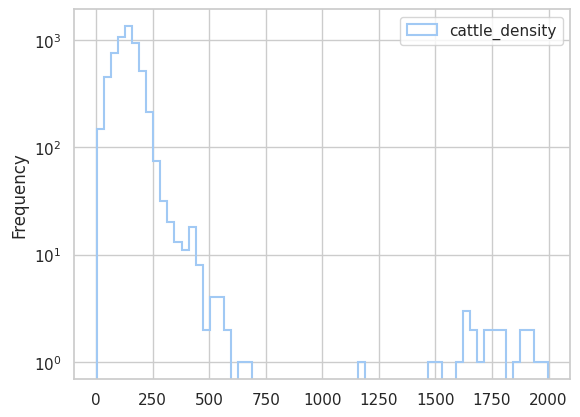

In [11]:
col_density = f'{animal}_density'

print(animal, livestock_data[np.logical_and.reduce([
    livestock_data[col_density] > 0.001
])][[col_density]].quantile(q=[0.0,0.01,0.02,0.03,0.04,0.05,0.5,0.95,0.975,0.98,0.99,1.0]).round())

livestock_data[[col_density]].plot(kind='hist', bins=64,  histtype='step', linewidth=1.5, log=True, legend=True)

In [12]:
zero_val = 0.001

col_density = f'{animal}_density'
col_ind = f'{animal}_ind'

n_samples = np.sum(livestock_data[col_ind] == 1)

mask = np.logical_and.reduce([
    livestock_data[col_ind] == 1,
    livestock_data[col_density] > 0
])

#q02 = livestock_data[mask][col_density].quantile(0.02)
#q02_mask = np.logical_and.reduce([
#    livestock_data[col_ind] == 1,
#    livestock_data[col_density] <= q02
#])

#print(animal, (np.sum(q02_mask) / n_samples) * 100, q02)
#livestock_data.loc[q02_mask,col_density] = zero_val

q98 = livestock_data[mask][col_density].quantile(0.99)
q98_mask = np.logical_not(np.logical_and.reduce([
    livestock_data[col_ind] == 1,
    livestock_data[col_density] >= q98
]))

print(animal, (np.sum(q98_mask) / n_samples) * 100, q98)
livestock_data = livestock_data[q98_mask]

cattle 98.9961253962663 419.43930253346696


## Train/test split

In [13]:
test_pct = 0.2

uniq_names = livestock_data['gazName'].unique()
n_names = len(uniq_names)
n_test_names = int(n_names * test_pct)

test_names = uniq_names[np.random.randint(n_names, size=n_test_names)]
print(f"Number municipalities for test: {n_test_names}")
print(test_names)

Number municipalities for test: 49
['Brazil.Goiás.Palestina de Goiás' 'Brazil.Goiás.Jaupaci'
 'Brazil.Goiás.ITAJÁ' 'Brazil.Goiás.Edéia' 'Brazil.Goiás.Jaupaci'
 'Brazil.Goiás.Barro Alto' 'Brazil.Goiás.CERES' 'Brazil.Goiás.Morrinhos'
 'Brazil.Goiás.CAMPO LIMPO DE GOIÁS'
 'Brazil.Goiás.Santo Antônio do Descoberto'
 'Brazil.Goiás.Petrolina de Goiás' 'Brazil.Goiás.Damianópolis'
 'Brazil.Goiás.Caturaí' 'Brazil.Goiás.CERES' 'Brazil.Goiás.Niquelândia'
 'Brazil.Goiás.Iaciara' 'Brazil.Goiás.Guapó' 'Brazil.Goiás.Cumari'
 'Brazil.Goiás.Vicentinópolis' 'Brazil.Goiás.Novo Planalto'
 'Brazil.Goiás.Mineiros' 'Brazil.Goiás.Quirinópolis'
 'Brazil.Goiás.CALDAZINHA' 'Brazil.Goiás.Itumbiara'
 'Brazil.Goiás.Vianópolis' 'Brazil.Goiás.Heitoraí'
 'Brazil.Goiás.Goianápolis' 'Brazil.Goiás.Campinorte' 'Brazil.Goiás.ITAJÁ'
 'Brazil.Goiás.Joviânia' 'Brazil.Goiás.Bela Vista de Goiás'
 'Brazil.Goiás.Urutaí' 'Brazil.Goiás.Buriti Alegre'
 'Brazil.Goiás.Heitoraí' 'Brazil.Goiás.Montividiu do Norte'
 'Brazil.Goiás.Anhangu

In [14]:
livestock_data.loc[:,['ml_type']] = 'train'
livestock_data.loc[livestock_data['gazName'].isin(test_names), 'ml_type'] = 'test'
livestock_data['ml_type'].value_counts()

ml_type
train    4643
test      978
Name: count, dtype: int64

In [15]:
train_mask = (livestock_data['ml_type'] == 'train')
test_mask = (livestock_data['ml_type'] == 'test')

## Modeling params

In [16]:
covs = list(livestock_data.columns[9:-2])
target = 'cattle_density'
group_col = 'gazName'
cv_folds = 5

## Random Forest regressor

In [35]:
pred_cv = cross_val_predict(
    RandomForestRegressor(criterion='poisson', n_jobs=-1), 
    livestock_data[train_mask][covs], 
    livestock_data[train_mask][target], 
    n_jobs = cv_folds, 
    groups = livestock_data[train_mask][group_col], 
    verbose = True,
    cv = GroupKFold(cv_folds)
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.6s finished


/skmap/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


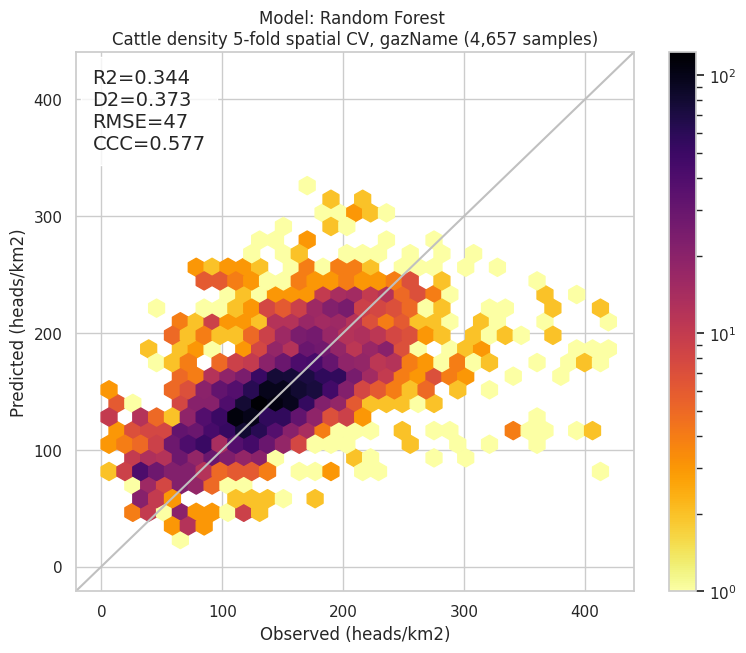

In [36]:
cv_df = pd.DataFrame({'pred':pred_cv, 'true':livestock_data[train_mask][target], 'weight': 1})

title_base=f'{animal.capitalize()} density 5-fold spatial CV, {group_col}'
misc.density_plot(cv_df, 'Random Forest', title_base=title_base, unit='heads/km2')

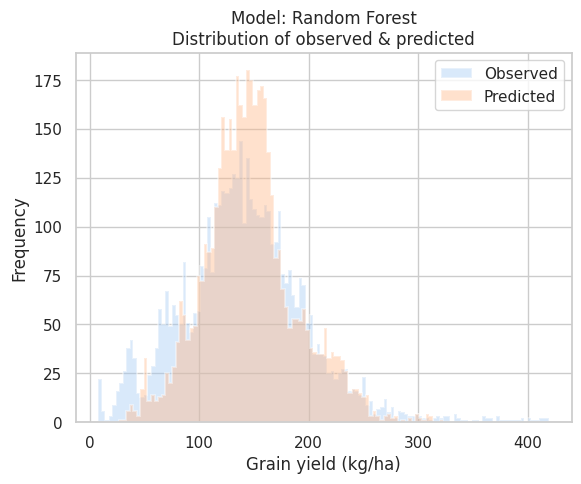

In [37]:
misc.histogram_plot(cv_df, 'Random Forest')

In [38]:
rf = RandomForestRegressor(criterion='poisson', n_jobs=-1)

rf.fit(livestock_data[train_mask][covs], livestock_data[train_mask][target]) 

test = rf.predict(livestock_data[test_mask][covs])

/skmap/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


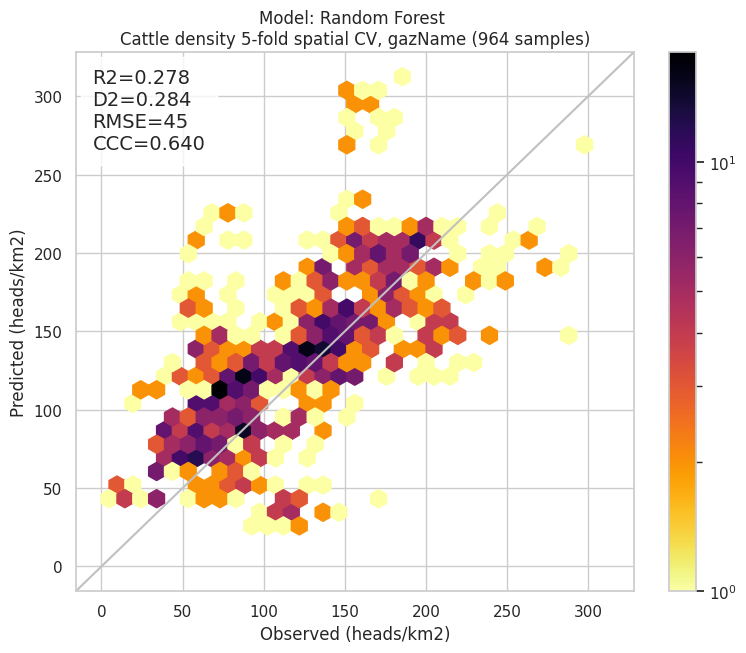

In [39]:
test_df = pd.DataFrame({'pred':test, 'true':livestock_data[test_mask][target], 'weight': 1})

title_base=f'{animal.capitalize()} density 5-fold spatial CV, {group_col}'
misc.density_plot(test_df, 'Random Forest', title_base=title_base, unit='heads/km2')

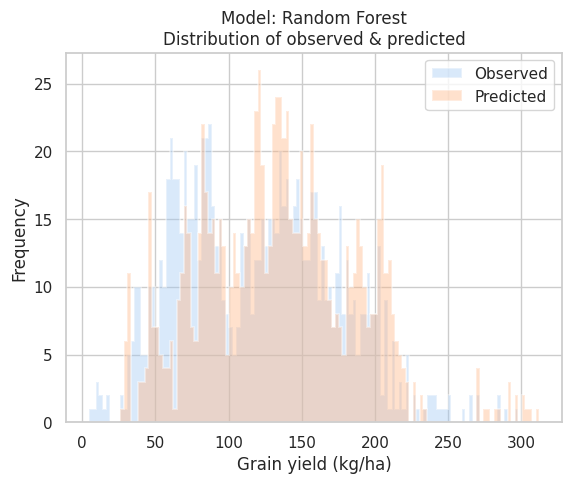

In [40]:
misc.histogram_plot(test_df, 'Random Forest')

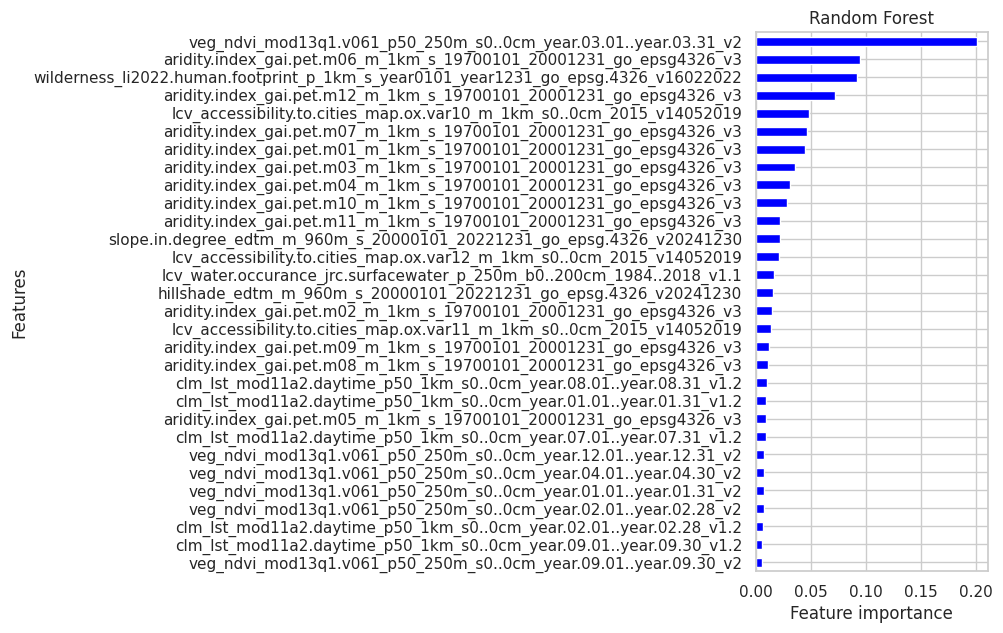

In [41]:
misc.importance_plot(rf.feature_names_in_, rf.feature_importances_, title="Random Forest")

## Auto-ML model

In [17]:
from evalml.problem_types import detect_problem_type
from evalml.automl import get_default_primary_search_objective

problem_type = detect_problem_type(livestock_data[target]).name

search_params = {
    'X_train': livestock_data[train_mask][covs],
    'y_train': livestock_data[train_mask][target],
    'X_holdout': livestock_data[test_mask][covs],
    'y_holdout': livestock_data[test_mask][target],
    'problem_type': problem_type,
    'objective': get_default_primary_search_objective(problem_type),
    'optimize_thresholds': True,
    'verbose': True,
    'max_iterations': 10
}

In [22]:
#!pip install anywidget 
#!pip install ipywidgets==7.7.5

AutoMLSearch will use the holdout set to score and rank pipelines.


INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:__init__()- AutoMLSearch will use the holdout set to score and rank pipelines.



*****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- 
*****************************


* Beginning pipeline search *


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- * Beginning pipeline search *


*****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- *****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- 


Optimizing for R2. 


INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:search()- Optimizing for R2. 


Greater score is better.



INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:search()- Greater score is better.



Using SequentialEngine to train and score pipelines.


INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:search()- Using SequentialEngine to train and score pipelines.


Searching up to 10 pipelines. 


INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:search()- Searching up to 10 pipelines. 


Allowed model families: 



INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:search()- Allowed model families: 



Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline


INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:_add_baseline_pipelines()- Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline


Mean Baseline Regression Pipeline:


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- Mean Baseline Regression Pipeline:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: -0.001
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_searc

	Finished cross validation - mean R2: -0.001


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: -0.001


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: -0.014


	Finished holdout set scoring - R2: -0.014


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: -0.014



*****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- 
*****************************


* Evaluating Batch Number 1 *


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- * Evaluating Batch Number 1 *


*****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- *****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- 


Random Forest Regressor w/ Imputer + RF Regressor Select From Model:


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- Random Forest Regressor w/ Imputer + RF Regressor Select From Model:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.780
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.765


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.765


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: 0.088


	Finished holdout set scoring - R2: 0.088


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: 0.088



*****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- 
*****************************


* Evaluating Batch Number 2 *


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- * Evaluating Batch Number 2 *


*****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- *****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- 


Extra Trees Regressor w/ Imputer + Select Columns Transformer:


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- Extra Trees Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.582
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.575


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.575


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: 0.327


	Finished holdout set scoring - R2: 0.327


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: 0.327


XGBoost Regressor w/ Imputer + Select Columns Transformer:


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- XGBoost Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.883
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.867


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.867


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: 0.211


	Finished holdout set scoring - R2: 0.211


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: 0.211


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4492
[LightGBM] [Info] Number of data points in the train set: 3095, number of used features: 24
[LightGBM] [Info] Start training from score 137.481849
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4493
[LightGBM] [Info] Number of data points in the train set: 3095, number of used features: 24
[LightGBM] [Info] Start training from score 136.985953
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4491
[LightGBM] [Info] Number of data points in the train set: 3096, number of used features: 24
[LightGBM] [Info] Start tr

INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- LightGBM Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.797
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.789


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.789


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: 0.350


	Finished holdout set scoring - R2: 0.350


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: 0.350


Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.488
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.475


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.475


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: 0.382


	Finished holdout set scoring - R2: 0.382


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: 0.382



*****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- 
*****************************


* Evaluating Batch Number 3 *


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- * Evaluating Batch Number 3 *


*****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- *****************************


INFO	Task(Task-3) evalml.automl.automl_search.verbose:logger.py:log_title()- 


Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.400
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.398


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.398


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: 0.320


	Finished holdout set scoring - R2: 0.320


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: 0.320


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4492
[LightGBM] [Info] Number of data points in the train set: 3095, number of used features: 24
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 137.481849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- LightGBM Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.769
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.758


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.758


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: -0.026


	Finished holdout set scoring - R2: -0.026


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: -0.026


Extra Trees Regressor w/ Imputer + Select Columns Transformer:


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- Extra Trees Regressor w/ Imputer + Select Columns Transformer:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.765
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.758


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.758


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: 0.374


	Finished holdout set scoring - R2: 0.374


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: 0.374


Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer:


	Starting cross validation


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting cross validation
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 0
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 0: R2 score: 0.428
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring on fold 1
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 1: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search

	Finished cross validation - mean R2: 0.426


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished cross validation - mean R2: 0.426


	Starting holdout set scoring


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Starting holdout set scoring
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 		Training and scoring entire dataset
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: starting training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: finished training
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: Scoring trained pipeline
DEBUG	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 			Fold 2: R2 score: 0.351


	Finished holdout set scoring - R2: 0.351


INFO	Task(Task-3) evalml.automl.automl_search.verbose:engine_base.py:write_to_logger()- 	Finished holdout set scoring - R2: 0.351



Search finished after 10.56 seconds    


INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:search()- 
Search finished after 10.56 seconds    


Best pipeline: Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer


INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:search()- Best pipeline: Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer


Best pipeline R2: 0.381699


INFO	Task(Task-3) evalml.automl.automl_search.verbose:automl_search.py:search()- Best pipeline R2: 0.381699


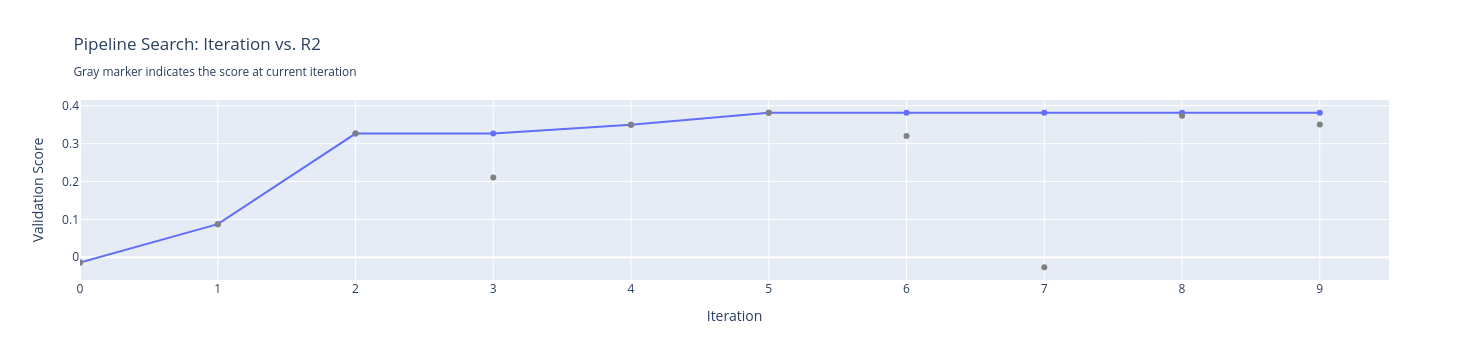

{1: {'Random Forest Regressor w/ Imputer + RF Regressor Select From Model': 2.329298496246338,
  'Total time of batch': 2.4483861923217773},
 2: {'Extra Trees Regressor w/ Imputer + Select Columns Transformer': 0.5952329635620117,
  'XGBoost Regressor w/ Imputer + Select Columns Transformer': 1.13285231590271,
  'LightGBM Regressor w/ Imputer + Select Columns Transformer': 0.6428172588348389,
  'Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer': 1.0216779708862305,
  'Total time of batch': 3.8391735553741455},
 3: {'Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer': 0.9866518974304199,
  'LightGBM Regressor w/ Imputer + Select Columns Transformer': 0.552260160446167,
  'Extra Trees Regressor w/ Imputer + Select Columns Transformer': 1.2650575637817383,
  'Total time of batch': 4.1219706535339355}}

In [23]:
from evalml import AutoMLSearch

automl = AutoMLSearch(**search_params)
automl.search(interactive_plot=False)

In [24]:
automl.rankings

,id,pipeline_name,search_order,ranking_score,holdout_score,mean_cv_score,standard_deviation_cv_score,percent_better_than_baseline,high_variance_cv,parameters
0,5,Elastic Net Regressor w/ Imputer + Standard Sc...,5,0.381699,0.381699,0.475368,0.017721,80647.682029,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,8,Extra Trees Regressor w/ Imputer + Select Colu...,8,0.374082,0.374082,0.757758,0.014366,128496.522636,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,4,LightGBM Regressor w/ Imputer + Select Columns...,4,0.350067,0.350067,0.788505,0.007590,133706.492615,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,3,XGBoost Regressor w/ Imputer + Select Columns ...,3,0.210676,0.210676,0.866783,0.015044,146970.046706,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,1,Random Forest Regressor w/ Imputer + RF Regres...,1,0.087504,0.087504,0.765034,0.015441,129729.412755,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mean Baseline Regression Pipeline,0,-0.014005,-0.014005,-0.000590,0.000510,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}


In [25]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])


***********************************************************************************


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:logger.py:log_title()- 
***********************************************************************************


* Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer *


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:logger.py:log_title()- * Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer *


***********************************************************************************


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:logger.py:log_title()- ***********************************************************************************


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:logger.py:log_title()- 


Problem Type: regression


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:pipeline_base.py:describe()- Problem Type: regression


Model Family: Linear


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:pipeline_base.py:describe()- Model Family: Linear


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:logger.py:log_subtitle()- 


Pipeline Steps


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:logger.py:log_subtitle()- Pipeline Steps


INFO	Task(Task-3) evalml.pipelines.pipeline_base.describe:logger.py:log_subtitle()- ==============


1. Imputer


INFO	Task(Task-3) evalml.pipelines.component_graph.describe:component_graph.py:describe()- 1. Imputer


	 * categorical_impute_strategy : most_frequent


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * categorical_impute_strategy : most_frequent


	 * numeric_impute_strategy : mean


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * numeric_impute_strategy : mean


	 * boolean_impute_strategy : most_frequent


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * boolean_impute_strategy : most_frequent


	 * categorical_fill_value : None


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * categorical_fill_value : None


	 * numeric_fill_value : None


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * numeric_fill_value : None


	 * boolean_fill_value : None


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * boolean_fill_value : None


2. Standard Scaler


INFO	Task(Task-3) evalml.pipelines.component_graph.describe:component_graph.py:describe()- 2. Standard Scaler


3. Select Columns Transformer


INFO	Task(Task-3) evalml.pipelines.component_graph.describe:component_graph.py:describe()- 3. Select Columns Transformer


	 * columns : ['hillshade_edtm_m_960m_s_20000101_20221231_go_epsg.4326_v20241230', 'slope.in.degree_edtm_m_960m_s_20000101_20221231_go_epsg.4326_v20241230', 'lcv_accessibility.to.cities_map.ox.var10_m_1km_s0..0cm_2015_v14052019', 'lcv_accessibility.to.cities_map.ox.var11_m_1km_s0..0cm_2015_v14052019', 'lcv_accessibility.to.cities_map.ox.var12_m_1km_s0..0cm_2015_v14052019', 'aridity.index_gai.pet.m01_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m02_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m03_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m04_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m05_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m06_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m07_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m08_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m09_m_1km_s_19700101_20001231_go_epsg4326

INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * columns : ['hillshade_edtm_m_960m_s_20000101_20221231_go_epsg.4326_v20241230', 'slope.in.degree_edtm_m_960m_s_20000101_20221231_go_epsg.4326_v20241230', 'lcv_accessibility.to.cities_map.ox.var10_m_1km_s0..0cm_2015_v14052019', 'lcv_accessibility.to.cities_map.ox.var11_m_1km_s0..0cm_2015_v14052019', 'lcv_accessibility.to.cities_map.ox.var12_m_1km_s0..0cm_2015_v14052019', 'aridity.index_gai.pet.m01_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m02_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m03_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m04_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m05_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m06_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m07_m_1km_s_19700101_20001231_go_epsg4326_v3', 'aridity.index_gai.pet.m08_m_1km_s

4. Elastic Net Regressor


INFO	Task(Task-3) evalml.pipelines.component_graph.describe:component_graph.py:describe()- 4. Elastic Net Regressor


	 * alpha : 0.0001


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * alpha : 0.0001


	 * l1_ratio : 0.15


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * l1_ratio : 0.15


	 * max_iter : 1000


INFO	Task(Task-3) evalml.pipelines.components.component_base.describe:component_base.py:describe()- 	 * max_iter : 1000


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:logger.py:log_subtitle()- 


Training


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:logger.py:log_subtitle()- Training


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:logger.py:log_subtitle()- ========


Training for regression problems.


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:automl_search.py:describe_pipeline()- Training for regression problems.


Total training time (including CV): 1.0 seconds


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:automl_search.py:describe_pipeline()- Total training time (including CV): 1.0 seconds


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:logger.py:log_subtitle()- 


Cross Validation


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:logger.py:log_subtitle()- Cross Validation


----------------


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:logger.py:log_subtitle()- ----------------


               R2  ExpVariance  MaxError  MedianAE      MSE    MAE  Root Mean Squared Error # Training # Validation
0           0.488        0.488   230.039    21.591 1764.150 29.699                   42.002      3,095        1,548
1           0.483        0.483   249.644    21.830 1725.699 29.671                   41.542      3,095        1,548
2           0.455        0.455   260.316    22.202 1890.732 30.625                   43.483      3,096        1,547
mean        0.475        0.476   246.666    21.874 1793.527 29.998                   42.342          -            -
std         0.018        0.018    15.357     0.308   86.349  0.543                    1.014          -            -
coef of var 0.037        0.037     0.062     0.014    0.048  0.018                    0.024          -            -


INFO	Task(Task-3) evalml.automl.automl_search.describe_pipeline:automl_search.py:describe_pipeline()-                R2  ExpVariance  MaxError  MedianAE      MSE    MAE  Root Mean Squared Error # Training # Validation
0           0.488        0.488   230.039    21.591 1764.150 29.699                   42.002      3,095        1,548
1           0.483        0.483   249.644    21.830 1725.699 29.671                   41.542      3,095        1,548
2           0.455        0.455   260.316    22.202 1890.732 30.625                   43.483      3,096        1,547
mean        0.475        0.476   246.666    21.874 1793.527 29.998                   42.342          -            -
std         0.018        0.018    15.357     0.308   86.349  0.543                    1.014          -            -
coef of var 0.037        0.037     0.062     0.014    0.048  0.018                    0.024          -            -


In [26]:
best_pipeline = automl.best_pipeline

In [27]:
test = automl.best_pipeline.predict(livestock_data[test_mask][covs])

In [28]:
model_name = automl.rankings.iloc[0]["pipeline_name"]
model_name

'Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer'

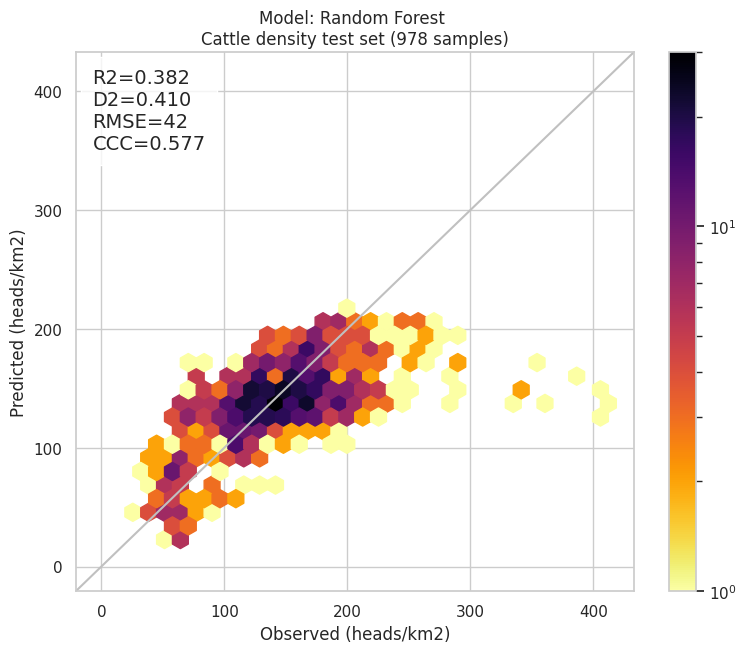

In [29]:
test_df = pd.DataFrame({'pred':test, 'true':livestock_data[test_mask][target], 'weight': 1})
title_base=f'{animal.capitalize()} density test set'
misc.density_plot(test_df, 'Random Forest', title_base=title_base, unit='heads/km2')

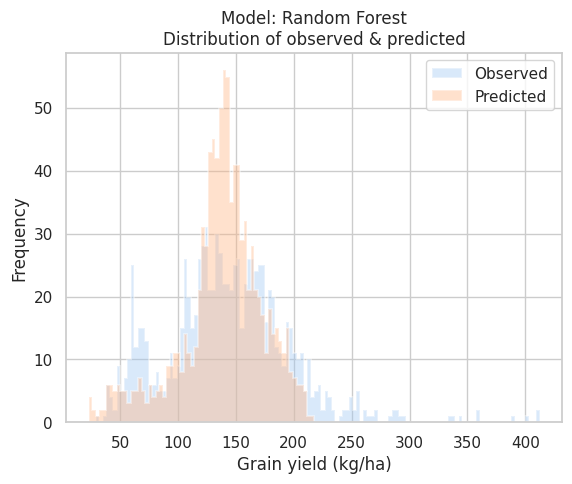

In [30]:
misc.histogram_plot(test_df, 'Random Forest')

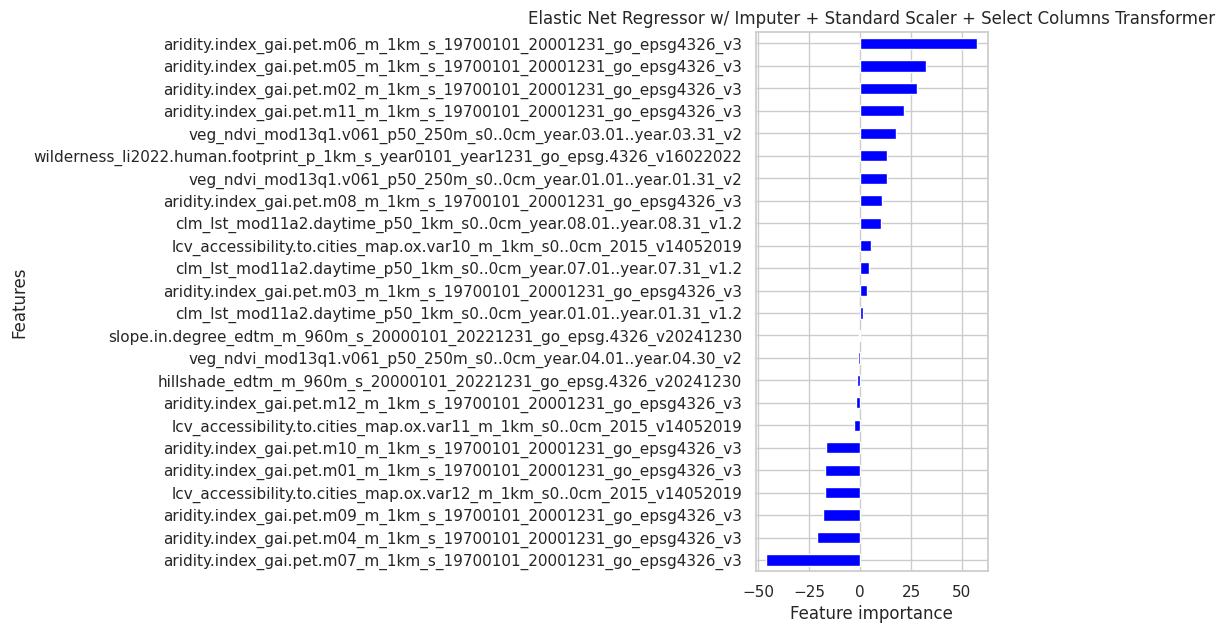

In [32]:
misc.importance_plot(best_pipeline.feature_importance.feature, best_pipeline.feature_importance.importance, 
             title=model_name)

# Spatiotemporal prediction

## Loading harmonized layer

In [34]:
year = 2020
n_jobs=8

In [35]:
covs_info = misc.gen_covs_info(static_covs, temporal_covs, [year], base_path)
mask_filter = covs_info['path'].str.contains('grassland.cropland')
mask_info = covs_info[mask_filter].reset_index(drop=True)
covs_info = covs_info[np.logical_not(mask_filter)].reset_index(drop=True)

covs_data = io.read_rasters_cpp(covs_info['path'], verbose=True, n_jobs=n_jobs)

[10:35:39] Reading 47 layers using window=Window(col_off=0, row_off=0, width=804, height=791) and array=(47, 635964)
[10:35:40] End


In [36]:
mask_data = io.read_rasters_cpp(mask_info['path'], verbose=True, n_jobs=n_jobs)

[10:35:40] Reading 1 layers using window=Window(col_off=0, row_off=0, width=804, height=791) and array=(1, 635964)
[10:35:40] End


## Prepare input data

In [38]:
pred_mask = np.logical_and.reduce([
    mask_data[0,:] > 0,
    np.logical_not(np.any(np.isnan(covs_data), axis=0))
])
pred_in = covs_data.T[pred_mask]

## Random Forest prediction

In [50]:
rf_density = np.empty((pred_mask.shape[0],1), dtype='float32')
rf_density[pred_mask,0] = rf.predict(pred_in)
rf_density = np.array(rf_density.T)

/skmap/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [51]:
rf_headcount = (mask_data / 100) * rf_density

In [52]:
io.save_rasters_cpp(covs_info['path'][0], rf_density, f'rf_{animal}_density_{year}', dtype = np.uint16, nodata=0)

['rf_cattle_density_2020.tif']

In [53]:
io.save_rasters_cpp(covs_info['path'][0], rf_headcount, f'rf_{animal}_headcount_{year}', dtype = np.uint16, nodata=0)

['rf_cattle_headcount_2020.tif']

## AutoML prediction

In [40]:
pred_in_df = pd.DataFrame(pred_in, columns=covs)
print(f"Model input shape: {pred_in_df.shape}")

Model input shape: (554326, 47)


In [41]:
# AutoML
aml_density = np.empty((pred_mask.shape[0],1), dtype='float32')
aml_density[pred_mask,0] = best_pipeline.predict(pred_in_df)
aml_density = np.array(aml_density.T)

In [42]:
aml_headcount = (mask_data / 100) * aml_density

In [44]:
io.save_rasters_cpp(covs_info['path'][0], aml_density, f'aml_{animal}_density_{year}', dtype = np.uint16, nodata=0)

['aml_cattle_density_2020.tif']

In [45]:
io.save_rasters_cpp(covs_info['path'][0], aml_headcount, f'aml_{animal}_headcount_{year}', dtype = np.uint16, nodata=0)

['aml_cattle_headcount_2020.tif']